# CNN ResNet-50
## Fiona Nicdao

In [1]:
# Residual Networks (ResNet-50)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

## Processing the Cifar10 Dataset
* normalize the data
* split optimizer into 70% training set and 30% testing set

# something wrong with the shape of training data

In [2]:
# load cifar
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Change the data to be split into 70% training set and 30% testing set
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
train_size = 0.7
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size,
                                                    random_state=42)
# validation
train_size = 0.9
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  train_size=train_size,
                                                  random_state=42)

x_train  = x_train / 255.0
x_test = x_test / 255.0
x_val = x_val / 255.0
y_train, y_test,y_val = y_train.flatten(), y_test.flatten(), y_val.flatten()

# one hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)


train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

def preprocess_image(image, label):
    image = tf.image.resize(image, (224,224))
    return image, label


train_dataset = (train_dataset.map(preprocess_image).batch(batch_size=128, drop_remainder=True))
test_dataset = (test_dataset.map(preprocess_image).batch(batch_size=128,drop_remainder=True))
val_dataset = (val_dataset.map(preprocess_image).batch(batch_size=128, drop_remainder=True))

# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)
# print(x_val.shape)
# print(y_val.shape)

# batch = next(iter(train_dataset))
# images, labels = batch

# for i in range(2):
#   print(images[i].shape)
#   print(labels)




170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


## ResNet-50



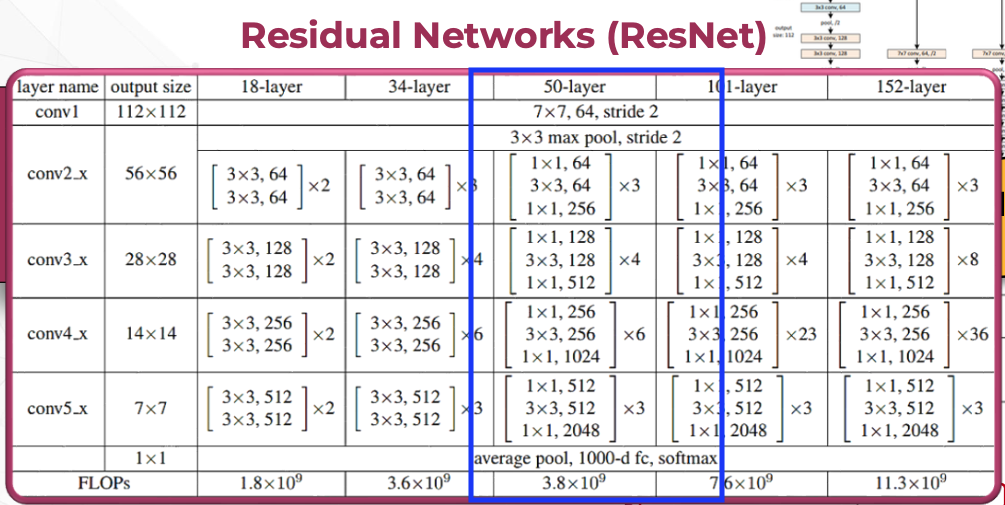

In [3]:
# ResNet 50 layers
class Residual(tf.keras.layers.Layer):
    ###############################################################
    #def __init__(self, filter_num, stride=1):
    def __init__(self, filter_num, stride=1, first_block=False):
    ###############################################################
        super(Residual, self).__init__()
        self.conv1=tf.keras.layers.Conv2D(filters=filter_num,
                                          kernel_size=(1,1),
                                          strides=stride,
                                          padding='same')
        self.bn1=tf.keras.layers.BatchNormalization()
        self.conv2=tf.keras.layers.Conv2D(filters=filter_num,
                                          kernel_size=(3,3),
                                          strides=1,
                                          padding='same')
        self.bn2=tf.keras.layers.BatchNormalization()
        # change for resnet 50 layer : filter_num*4
        self.conv3=tf.keras.layers.Conv2D(filters=filter_num*4,
                                          kernel_size=(1,1),
                                          strides=1,
                                          padding='same')
        self.bn3=tf.keras.layers.BatchNormalization()
        ###############################################################
        #if stride!=1:
        if stride!=1 or first_block == True:
        ###############################################################
            self.downsample=tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num*4,
                                                       kernel_size=(1,1),
                                                       strides=stride))
        else:
            ###############################################################
            # self.downsample= tf.keras.layers.Conv2D(filters=filter_num*4,
            #                                            kernel_size=(1,1),
            #                                            strides=stride)
            self.downsample=lambda x:x
            ###############################################################

    def call(self, inputs, training=None):
      x = self.conv1(inputs)
      x = self.bn1(x, training=training)
      x = tf.nn.relu(x)
      x = self.conv2(x)
      x = self.bn2(x, training=training)
      x = tf.nn.relu(x)
      x = self.conv3(x)
      x = self.bn3(x, training=training)

      identity = self.downsample(inputs)
      output = tf.nn.relu(identity + x)
      return output

class residual_block(tf.keras.layers.Layer):
    def __init__(self, filter_num, blocks, stride=1):
        super(residual_block, self).__init__()
        self.blocks=tf.keras.Sequential()
        ###############################################################
        # self.blocks.add(Residual(filter_num, stride))
        self.blocks.add(Residual(filter_num, stride, first_block=True))
        ###############################################################
        for _ in range(1, blocks):
            self.blocks.add(Residual(filter_num, stride=1))

    def call(self, inputs, training=None):
        output = self.blocks(inputs, training=training)
        return output


In [4]:
class resnet50(tf.keras.Model):
    def __init__(self, num_classes):
        super(resnet50, self).__init__()
        self.conv=tf.keras.layers.Conv2D(filters=64, kernel_size=(7,7),
                                         strides=2, padding='same')
        self.pool=tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2,
                                            padding='same')
        self.block1=residual_block(64,3,stride=1)
        self.block2=residual_block(128,4,stride=2)
        self.block3=residual_block(256, 6, stride=2)
        self.block4=residual_block(512, 3, stride=2)
        self.pool2=tf.keras.layers.GlobalAveragePooling2D()
        self.dropout=tf.keras.layers.Dropout(0.5)
        self.fc=tf.keras.layers.Dense(num_classes)

    def call(self, inputs, training=None):
        x=self.conv(inputs)
        x=self.pool(x)
        x=self.block1(x, training=training)
        x=self.block2(x, training=training)
        x=self.block3(x, training=training)
        x=self.block4(x, training=training)
        x=self.pool2(x)
        x=self.dropout(x)
        x=self.fc(x)
        return x

    def build_model(self):
        x=tf.keras.Input(shape=(224,224,3))
        return tf.keras.Model(inputs=[x], outputs=self.call(x,training=True))


In [5]:
resnet = resnet50(10)
model = resnet.build_model()
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 112, 112, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (residual_block)      │ (None, 56, 56, 256)         │         219,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_1 (residual_block)    │ (None, 28, 28, 512)         │       1,228,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_2 (residual_block)    │ (None, 14, 14, 1024)        │       7,124,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_3 (residual_block)    │ (None, 7, 7, 2048)          │      14,990,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,592,586 (90.00 MB)

 Trainable params: 23,547,274 (89.83 MB)

 Non-trainable params: 45,312 (177.00 KB)

obtain the training and testing accuracy

visualize the training history
* Adam optimizer with 1e-4 learning rating
* Batch size = 32
* Number of training epochs = 50
* dropout rate = 0.5

predict the last ten images in the test set


# issues with my fit, I think there is something wrong with my training data

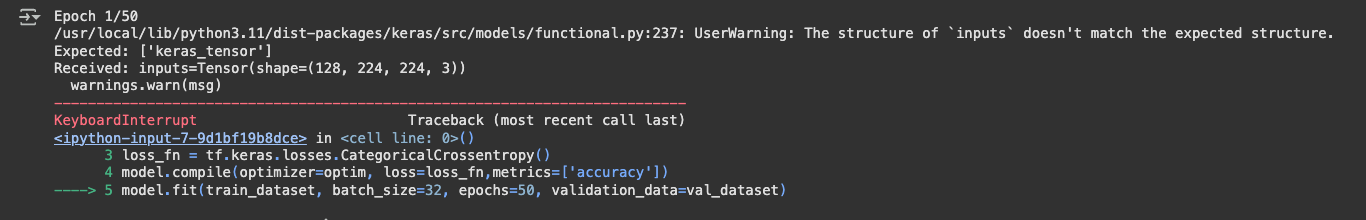

In [7]:
# obtain the traing and testing accuracy
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=optim, loss=loss_fn,metrics=['accuracy'])
model.fit(train_dataset, epochs=1, validation_data=val_dataset)
# something wrong with my fit / training data input shape

295/295 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.1162 - loss: 8.4568 - val_accuracy: 0.1033 - val_loss: 7.8623


need to fix this code -later

In [ ]:
def plot_history(hist_):
    plt.figure(figsize=(12, 10))
    plt.xlabel('Epoch',fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Error')
    plt.legend(["train", "validation"], loc="upper left", prop={'size': 20})

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_history(hist)

In [ ]:
score = model.evaluate(test_dataset, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

In [ ]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, ax = plt.subplots(2, 5, figsize=(15, 8))
ax = ax.flatten()

for i, (image, label) in enumerate(train_dataset.take(1)):
    #plottable_image = np.reshape(image, (32, 32, 3))
    for i in range(10):
      ax[i].imshow(image[i])
      ax[i].set_title("Prediction is: {}".format(CLASS_NAMES[model.predict(np.reshape(image[i], (1,96,96,3))).argmax()]), fontsize=12)
